<a href="https://colab.research.google.com/github/chuqasmi/GEN-AI-/blob/main/Copy_of_Link_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

import torch_geometric
print(torch_geometric.__version__)

1.12.0+cu113
     |████████████████████████████████| 7.9 MB 17.1 MB/s 
     |████████████████████████████████| 3.5 MB 34.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 30.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=bf137c46775f9e7a42110b7409d214a2870652d9fd2154da1f05c52897d9dcff
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
2.0.4


In [ ]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Graph autoencoder for link prediction


Reference: [code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/link_pred.py)


#### Transform and load data

We use RandomLinkSplit to perform an edge-level random split into training, validation and test sets of a Data or a HeteroData object.

Graph has 10556/2 = 5278 undirected edges and we set validation ratio as 0.1 and test ratio as 0.2.

Validation edge labels
*   pos  = 5278 * 0.1 ~ 527
*   neg  = 527
*   total = 1054

Test edge labels
*   pos = 5278 * 0.2 ~ 1055
*   neg = 1055
*   total = 2110

Train edge labels
*   pos = 5278 - 527 - 1055 = 3696
*   neg = 0
*   total = 3696

Message passing edges
*   train: message passing = 3696 * 2 = 7392
*   validation: message passing = train message passing = 7392
*   test: message passing = train message passing + validation edges (undirected) = 7392 + 527 * 2 = 8446

In [ ]:
# load the Cora dataset
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.10, num_test=0.20, neg_sampling_ratio = 1.0,
                  is_undirected=True, add_negative_train_samples=False),
])
dataset = Planetoid('./data/Planetoid', name='Cora', transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]
print(train_data)
print(val_data)
print(test_data)

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[3696], edge_label_index=[2, 3696])
Data(x=[2708, 1433], edge_index=[2, 7392], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[1054], edge_label_index=[2, 1054])
Data(x=[2708, 1433], edge_index=[2, 8446], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_label=[2110], edge_label_index=[2, 2110])


In [ ]:
(train_data.edge_index[0] <= train_data.edge_index[1]).sum()

tensor(3696, device='cuda:0')

#### Simple autoencoder model
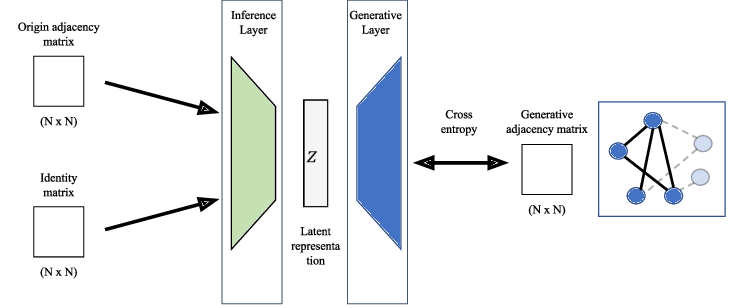

Encoder(Inference): Two layer Graph convolutional layer

Decoder(Generative): Pair-wise inner product of node imbeddings

[BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html): This loss combines a Sigmoid layer and the Binary Cross Entropy.

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        #return the indices of a non-zero element
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

#### Model Training
Training with new negative samples for each training epoch

Validation/Test evaluation with roc_auc_score (Area Under the Receiver Operating Characteristic Curve)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1))

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())



In [ ]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.6930, Val: 0.7063, Test: 0.6823
Epoch: 002, Loss: 0.6836, Val: 0.6974, Test: 0.6749
Epoch: 003, Loss: 0.7024, Val: 0.7133, Test: 0.6837
Epoch: 004, Loss: 0.6783, Val: 0.7357, Test: 0.7012
Epoch: 005, Loss: 0.6851, Val: 0.7583, Test: 0.7285
Epoch: 006, Loss: 0.6874, Val: 0.7718, Test: 0.7479
Epoch: 007, Loss: 0.6875, Val: 0.7638, Test: 0.7422
Epoch: 008, Loss: 0.6859, Val: 0.7468, Test: 0.7260
Epoch: 009, Loss: 0.6819, Val: 0.7334, Test: 0.7116
Epoch: 010, Loss: 0.6745, Val: 0.7244, Test: 0.7004
Epoch: 011, Loss: 0.6701, Val: 0.7215, Test: 0.6954
Epoch: 012, Loss: 0.6703, Val: 0.7287, Test: 0.7024
Epoch: 013, Loss: 0.6632, Val: 0.7506, Test: 0.7254
Epoch: 014, Loss: 0.6541, Val: 0.7742, Test: 0.7510
Epoch: 015, Loss: 0.6464, Val: 0.7810, Test: 0.7587
Epoch: 016, Loss: 0.6372, Val: 0.7777, Test: 0.7528
Epoch: 017, Loss: 0.6214, Val: 0.7762, Test: 0.7500
Epoch: 018, Loss: 0.6092, Val: 0.7870, Test: 0.7656
Epoch: 019, Loss: 0.5883, Val: 0.7945, Test: 0.7782
Epoch: 020, 

In [ ]:
z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

In [ ]:
final_edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [   0,    1,    2,  ..., 2705, 2706, 2707]], device='cuda:0')